## Esame Metodi Numerici  12 Giugno 2024 - Turno II Ore 12,30

## Esercizio 1
Si condiderino i due sistemi lineari:

     A  x = b 

    A1 x1 = b1

dove A, A1 sono le matrici dei coefficienti, b e b1 sono i termini noti, ed x ed x1 sono i vettori incongiti da determinare.
I dati di questi due sistemi lineari sono contenuti nel file **testII.mat**.


- Si implementino e si testino sui dati forniti almeno due metodi che sono adatti a risolvere sistemi lineari con le caratteristiche delle matrici dei coefficienti date in input.
                                      **punti 8**
- Si confrontino i risultati ottenuti e si giustifichino utilizzando  e richiamando gli aspetti teorici dei metodi implementati.
                                      **punti 3**


**Totale Punti 11**

Per la lettura dei dati procedere nel seguente modo:

``from scipy.io import loadmat``

``import numpy as np``

``dati = loadmat('testII')``

``A=dati["A"] ``

``A=A.astype(float)``

`` b=dati["b"] ``

`` b=b.astype(float)``

``A1=dati["A1"] ``

``A1=A1.astype(float)``

`` b1=dati["b1"] ``

`` b1=b1.astype(float)``


In [1]:
import numpy as np
import scipy as sp
import SolveTriangular as st
import matplotlib.pyplot as plt
import sympy as sym
from sympy import symbols, Matrix, lambdify

In [2]:
from scipy.io import loadmat
import numpy as np

dati = loadmat('testII')

A=dati["A"] 
A=A.astype(float)
b=dati["b"] 
b=b.astype(float)

print('[A] Dimensioni: {}x{}'.format(A.shape[0],A.shape[1]))
print('[A] Sparsità: ', (np.count_nonzero(A)/A.shape[0]**2)*100)
absA=np.abs(A)
print('[A] Diagonale strettamente dominante? ',np.all(2*np.diag(absA)>np.sum(absA,axis=1)))
print('[A] Simmetrica?', np.allclose(A.T,A))
print('[A] Definita Positiva?', np.all(np.linalg.eigvals(A)>0))
print('[A] Condizionamento: ', np.linalg.cond(A))
# Abbiamo una matrice di grandi dimensioni, sparsa, simmetrica e definita positiva
# Possiamo procedere con la soluzione tramite diversi metodi:
# Gauss-Seidel, Gauss-Seidel -> Per il teorema della convergenza del metodo
# - che dice che se la matrice è simmetrica e definita positiva allora il metodo converge.
# - (Converge anche se la matrice è a diagonale strettamente dominante)
# Metodi di discesa (steepest descent o conjugate gradient) che richiedono che la matrice sia simmetrica e definita positiva.

A1=dati["A1"]
A1=A1.astype(float)
b1=dati["b1"]
b1=b1.astype(float)
print('')
print('[A1] Dimensioni: {}x{}'.format(A1.shape[0],A1.shape[1]))
print('[A1] Sparsità: ', (np.count_nonzero(A1)/A1.shape[0]**2)*100)
absA1=np.abs(A1)
print('[A1] Diagonale strettamente dominante? ',np.all(2*np.diag(absA1)>np.sum(absA1,axis=1)))
print('[A1] Simmetrica?', np.allclose(A1.T,A1))
print('[A1] Definita Positiva?', np.all(np.linalg.eigvals(A1)>0))
print('[A1] Condizionamento: ', np.linalg.cond(A1))

# La matrice A1 ha praticamente le stesse proprietà della matrice 1 e quindi possiamo utilizzare gli stessi metodi
# - L'unica differenza è il condizionamento, bisognerà tenere particolare attenzione alle perturbazioni.

[A] Dimensioni: 500x500
[A] Sparsità:  14.2856
[A] Diagonale strettamente dominante?  False
[A] Simmetrica? True
[A] Definita Positiva? True
[A] Condizionamento:  100.00000000000276

[A1] Dimensioni: 500x500
[A1] Sparsità:  14.376
[A1] Diagonale strettamente dominante?  False
[A1] Simmetrica? True
[A1] Definita Positiva? True
[A1] Condizionamento:  15000.000000000473


In [3]:
def gauss_seidel(A,b,x0,toll,it_max):
    errore=1000
    d=np.diag(A)
    D=np.diag(d)
    E=np.tril(A,-1)
    F=np.triu(A,1)
    M=D+E
    N=-F

    # Convergence check
    invM=np.linalg.inv(M)
    T=invM@N
    eigenvalues=np.linalg.eigvals(T)
    spectralradius=np.max(np.abs(eigenvalues))
    #print("raggio spettrale Gauss-Seidel ",spectralradius)

    # print("Norm:", np.linalg.norm(T,2))
    
    it=0
    er_vet=[]
    while it<=it_max and errore>=toll:
        x,flag=st.Lsolve(M,b+N@x0) # Key Operation
        errore=np.linalg.norm(x-x0)/np.linalg.norm(x)
        er_vet.append(errore)
        x0=x.copy()
        it=it+1
    return x,it,er_vet

In [4]:
def steepestdescent(A,b,x0,itmax,tol):
    x=x0.copy()
    r=A@x-b
    it=0
    p=-r
    normb=np.linalg.norm(b)

    error=np.linalg.norm(r)/normb

    vec_sol=[]
    vec_sol.append(x.copy())
    vec_r=[]
    vec_r.append(error)

    #print(error,tol,it,itmax)
    while error>=tol and it<itmax:
        #print('Helo?')
        it=it+1
        
        Ap=A@p
        alpha=(r.T@r)/(p.T@Ap)
        
        x=x+alpha*p
        r=r+alpha*Ap

        vec_sol.append(x.copy())
        error=np.linalg.norm(r)/normb
        vec_r.append(error)
        p=-r # Max descent (Opposite of gradient)
        
    iterates=np.vstack([arr.T for arr in vec_sol]) # Only for graphical purpose

    return x,vec_r, iterates, it

In [5]:
def conjugate_gradient(A,b,x0,itmax,tol):
    n,m=A.shape
    if n!=m:
        print("Matrice non quadrata")
        return [],[]
    
    
   # inizializzare le variabili necessarie
    x = x0
    
    r = A@x-b
    p = -r 
    it = 0
    nb=np.linalg.norm(b)
    errore=np.linalg.norm(r)/nb
    vec_sol=[]
    vec_sol.append(x0.copy())
    vet_r=[]
    vet_r.append(errore)
# utilizzare il metodo del gradiente coniugato per calcolare la soluzione
    while errore>=tol and it<itmax:
        it=it+1
        Ap=A@p
        rtr_old=r.T@r
        alpha = rtr_old/(p.T@Ap) 
        x = x + alpha*p
        vec_sol.append(x.copy())
        r= r+alpha*Ap
        gamma=(r.T@r)/rtr_old
        errore=np.linalg.norm(r)/nb
        vet_r.append(errore)
        p = -r + gamma*p
   
    iterates_array = np.vstack([arr.T for arr in vec_sol])
    return x,vet_r,iterates_array,it

Raggio spettrale Gauss-Seidel  0.9399020442983489
Fattore di convergenza Steepest descent:  0.9801980198019807
Fattore di convergenza Conjugate Gradient:  0.8181818181818205


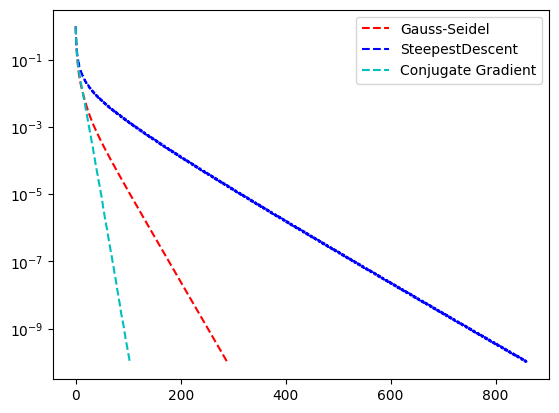

In [6]:
x0=np.zeros_like(b)
x01=np.zeros_like(b1)
toll=1e-10
itmax=2000
#print('[A] Gauss-Seidel:')
xg,itg,errg=gauss_seidel(A,b,x0,toll,itmax)
#print('[A] Soluzione: ',xg,' iterazioni: ',itg)
#print('[A] Steepest-Descend:')
xs,vet_r,its_arrs,its=steepestdescent(A,b,x0,itmax,toll)
#print('[A] Soluzione: ',xs,' iterazioni: ',its)
xc,vet_rc,its_arrc,itc=conjugate_gradient(A,b,x0,itmax,toll)
plt.semilogy(range(len(errg)),errg,'r--',range(len(vet_r)),vet_r,'b--',range(len(vet_rc)),vet_rc,'c--')
plt.legend(['Gauss-Seidel','SteepestDescent','Conjugate Gradient'])

# Calcoliamo il fattore di convergenza dei metodi:
print('Raggio spettrale Gauss-Seidel  0.9399020442983489')
# Molto vicino a 1 -> Convergenza lenta
print('Fattore di convergenza Steepest descent: ',(np.linalg.cond(A)-1)/(np.linalg.cond(A)+1))
print('Fattore di convergenza Conjugate Gradient: ',(np.sqrt(np.linalg.cond(A))-1)/(np.sqrt(np.linalg.cond(A))+1))

# Da questi fattori possiamo notare che Conjugate gradient è il metodo migliore

# Esercizio 2

-  Si consideri la funzione $$f(x)=2\cdot x^4-(7/2) \cdot x^3+(3/4) \cdot x^2+x-1/4$$  

-  Si rappresenti il grafico della funzione in [-1,2] e si determini in quanti punti la funzione si annulla.  **[punti: 1]**

-  Si implementi  il metodo di Newton per il calcolo degli zeri di una funzione non lineare. **[punti: 3]**

-  Si implementi il metodo di Bisezione per il calcolo degli zeri di una funzione non lineare. **[punti: 3]**

-  Osservando il grafico della funzione, si identifichi,  per ogni punto in cui si annulla, un opportuno intervallo che lo contenga. Si applichi il metodo di Bisezione per determinare lo zero della funzione in tale sottointervallo.  Si dica se è possibile calcolare tutti gli zeri facendo uso del metodo di bisezione, richiamando il teorema su cui si basa il metodo di bisezione.  **[punti: 2]**

-  Osservando il grafico della funzione, si identifichi,  per ogni punto in cui si annulla, un opportuno iterato iniziale in un intorno dello zero e si utilizzi  il metodo di Newton per determinare lo zero della funzione. Si calcoli l'ordine del metodo usando la funzione stima_ordine.
   **[punti: 2]**

-  Nel caso in cui si verifichi che il metodo di Newton abbia ordine 1, spiegare il perchè richiamando la teoria e modificare il metodo affinchè il suo ordine sia 2.  **[punti: 3]**

  **Totale punti 14**





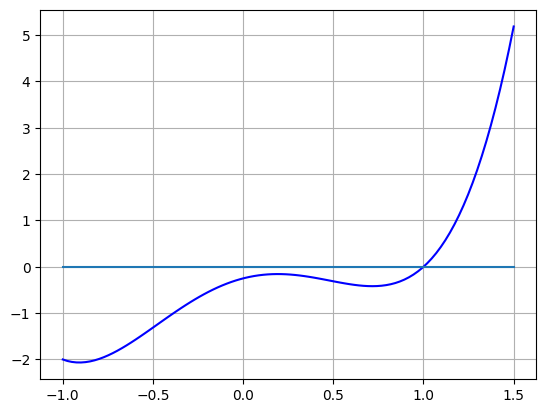

In [7]:
x=sym.symbols('x')
fs = 2*x**4-(7/2)*x**2+(3/4)*x**2+x-(1/4)
dfs=sym.diff(fs,x,1) #Il secondo argomento rappresenta la variabile rispetto a cui derivare e l'ultima l'ordine della derivata
fp=lambdify(x,dfs,np)  #l'ultimo argomento np (nickaname di numpy) serve per specificare che la lambda function 
#può prendere come argomento un numpy array ed eseguire l'operazione su tutte le sue componenti.
f=lambdify(x,fs,np)

# f=lambda x: 2*x**4-(7/2)*x**2+(3/4)*x**2+x-(1/4)
xx=np.linspace(-1,1.5,100)
plt.plot(xx,f(xx),'b-',xx,np.zeros_like(xx))
plt.grid(True)
# La funzione (nell'intervallo dato [-1,2]) si annulla in un unico punto (graficamente circa x=1.0)
a=0
b=1.5
x0=0.5
toll=1e-10
itmax=200

In [11]:
import math
def sign(x):
  """
  Funzione segno che restituisce 1 se x è positivo, 0 se x è zero e -1 se x è negativo.
  """
  return math.copysign(1, x)

In [15]:
def metodo_bisezione(fname, a, b, tolx):
    """
    Implementa il metodo di bisezione per il calcolo degli zeri di un'equazione non lineare.
    
    Parametri:
    f: La funzione da cui si vuole calcolare lo zero.
    a: L'estremo sinistro dell'intervallo di ricerca.
    b: L'estremo destro dell'intervallo di ricerca.
    tol: La tolleranza di errore.
    
    Restituisce:
    Lo zero approssimato della funzione, il numero di iterazioni e la lista di valori intermedi.
    """
    fa=fname(a)
    fb=fname(b)
    if sign(fa)*sign(fb)>=0:
        print("Non è possibile applicare il metodo di bisezione \n")
        return None, None,None
    
    it = 0
    v_xk = []
    
    
    while abs(b - a) > tolx:
        xk = a+(b-a)/2
        v_xk.append(xk)
        it += 1
        fxk=fname(xk)
        if fxk==0:
            return xk, it, v_xk
        
        if sign(fa)*sign(fxk)<0:  #la radice si trova nell'intervallo [a, xk].
            b = xk
            fb=fxk
        elif sign(fxk)*sign(fb)<0:   #la radice si trova nell'intervallo [xk, b].
            a = xk
            fa=fxk

    
    return xk, it, v_xk

def newton(fname,fpname,x0,tolx,tolf,nmax):
  
    xk=[]
   
    it=0
    errorex=1+tolx
    erroref=1+tolf
    while it<nmax and  erroref>=tolf and errorex>=tolx: #abs(d)>=tolx*abs(x1) :
       
       fx0=fname(x0)
       if abs(fpname(x0))<=np.spacing(1): #Se la derivata prima e' pià piccola della precisione di macchina stop
            print(" derivata prima nulla in x0")
            return None, None,None
       d=fx0/fpname(x0)
       '''
       #x1= ascissa del punto di intersezione tra  la retta che passa per il punto
       (xi,f(xi)) ed è tangente alla funzione f(x) nel punto (xi.f(xi))  e l'asse x
       '''
       x1=x0-d  
       fx1=fname(x1)
       erroref=np.abs(fx1)
       if x1!=0:
            errorex=abs(d)/abs(x1)
       else:
            errorex=abs(d) 

       it=it+1
       x0=x1
       xk.append(x1)
      
    if it==nmax:
        print('Newton: raggiunto massimo numero di iterazioni \n')
        
    
    return x1,it,xk

In [23]:
solbis,itb,vxkb=metodo_bisezione(f,a,b,toll)
solNewton,itn,xkn=newton(f,fp,x0,toll,toll,itmax)
print('Soluzione Bisezione: {}, Soluzione Newton: {}'.format(solbis,solNewton))

Soluzione Bisezione: 1.0000000000291038, Soluzione Newton: 1.000000000007009


In [24]:
def stima_ordine(xk,iterazioni):
    #Vedi dispensa allegata per la spiegazione
    
    k=iterazioni-4
    p=np.log(abs(xk[k+2]-xk[k+3])/abs(xk[k+1]-xk[k+2]))/np.log(abs(xk[k+1]-xk[k+2])/abs(xk[k]-xk[k+1]));
    
    ordine=p
    return ordine

In [27]:
print('Stima ordine bisezione: {}, Stima Ordine newton {}'.format(stima_ordine(vxkb,itb),stima_ordine(xkn,itn)))

Stima ordine bisezione: 1.0, Stima Ordine newton 2.0083419823167747


## Domande Intelligenza Artificiale
**NB: Ogni risposta esatta +0.5 punti, ogni risposta errata -0.5 punti. La mancanza di risposta 0 punti**

**1 Risolvere un problema mediante Machine Learning significa:**

 -  Fornire alla macchina i dati affinchè impari da sola a risolvere il problema

 - Fornire alla macchina solo dati etichettati affinchè impari da sola a risolvere il problema

 - Fornire alla macchina solo dati non etichettati affinchè impari da sola a risolvere il problema

 - Fornire alla macchina le esatte istruzioni per risolvere il problema

**SOLUZIONE**: Punto 1

**2  A cosa serve il validation set?**

-  A trovare i migliori iperparametri del modello

-  Ad addestrare il modello

-  A testare il modello

-  A trovare le etichette dei dati di input

**SOLUZIONE**: Punto 1

**3  Cosa è un Multi-Layer Perceptron?**

-  Una rete multi-livello composta da neuroni completamente connessi

-  Una rete muti-livello composta da livelli convolutivi e neuroni completamente connessi

-  Una rete a singolo livello composta da neuroni completamente connessi

- Un neurone artificiale con un determinato input e determinati valori di uscita

**SOLUZIONE**: Punto 1

**4 Il livello softmax**

- Trasforma i digits della rete in probabilità

- Trasforma le probabilità della rete in digits

-  Normalizza i valori di input della rete

-  È indispensabile nel task di regressione


**SOLUZIONE**: Punto 1

**5 In cosa consiste il task di regressione?**

· Nel predire un valore continuo in output

· Nel predire una classe in output

· Nel predire un gruppo di appartenenza del dato di input

· Nel predire una categoria in output

**SOLUZIONE**: Punto 1

## Domande Aperte

**6. ** Forward e backward Propagation per l'allenamento di una rete neurale** [punti 1.5]

**7 Metodo di ottimizzazione del gradient descent con momento**. Motivazioni e formula di aggiornamento dei pesi e commenti. [punti 3]